In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit


import sys
sys.path.append('../')
from custom_tools import plot_2D_pulse, CustomInstrumentJ1808

data_directory = '/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/model_data/'
datastring = data_directory + 'synthetic/J1808_synthetic_realisation.dat'  

counts = np.loadtxt(datastring)
phase_edge = np.linspace(0.0, 1.0, 33)

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1


In [2]:
channel_low = 20
channel_hi = 300 #600
max_input = 1400 #2000

NICER = CustomInstrumentJ1808.from_response_files(ARF =  data_directory + '/J1808/ni2584010103mpu7_arf_aeff.txt',
                                                  RMF =  data_directory + 'J1808/ni2584010103mpu7_rmf_matrix.txt',
                                                  channel_edges =  data_directory + 'J1808/ni2584010103mpu7_rmf_energymap.txt',
                                                  channel_low=channel_low,
                                                  channel_hi=channel_hi,
                                                  max_input=max_input)

energy_edge = NICER.channel_edges

Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.


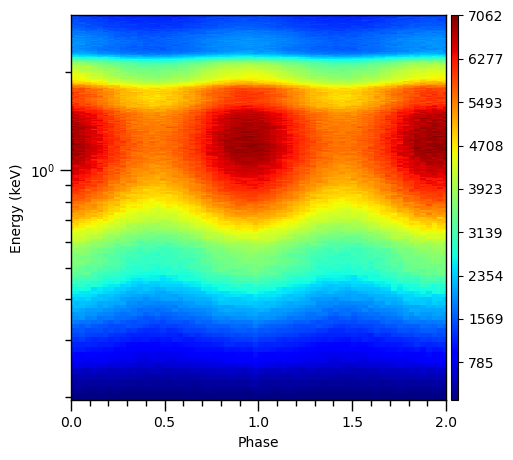

In [3]:
ax = plot_2D_pulse((counts,),
                   x=phase_edge,
                   shift=[0.],
                   y=energy_edge[:-1], #channels,
                   ylabel=r'Energy (keV)',
                   figsize=(5,5),
                   cm=cm.jet,
                   num_rotations=2.0,
                   normalize=False)

plt.show()

# Fitting

In [4]:
def sinfunc(phase, A, p, c):
    
    return A * np.sin(phase*2.0*np.pi + p) + c


def sin2func(phase, A, p, c, A2, p2):

        return A*np.sin(phase*2.0*np.pi + p) + A2*np.sin(phase*4.0*np.pi + p2) + c

In [5]:
def fit2sin(phase, counts):
    
    
    #counts=data.sum(axis=0)

    c0 = 6500
    A0 = 1000
    p0 = 0.15*2.0*np.pi
    A20 = 100
    p20 = 0.01*2.0*np.pi

    guess = [A0, p0,c0, A20, p20]
    popt, pcov = scipy.optimize.curve_fit(sin2func, phase, counts, p0=guess)
    #A, p, c, A2, p2 = popt
    #print(popt)
    
    return popt 

 
def fitsin(phase, counts):
    
    
    #counts=data.sum(axis=0)

    c0 = 6500
    A0 = 1000
    p0 = 0.15*2.0*np.pi
    A20 = 100
    p20 = 0.01*2.0*np.pi

    guess = [A0, p0,c0]
    popt, pcov = scipy.optimize.curve_fit(sinfunc, phase, counts, p0=guess)
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr

In [6]:
# def get_values_from_edges(edges):
#     values_len = len(edges)-1
#     values = np.empty(values_len)
#     for i in range(values_len):
#         values[i] = (edges[i]+edges[i+1])/2
#     return values

from custom_tools import get_values_from_edges

phase = get_values_from_edges(phase_edge)
energy = get_values_from_edges(energy_edge)

n_energies = len(energy)

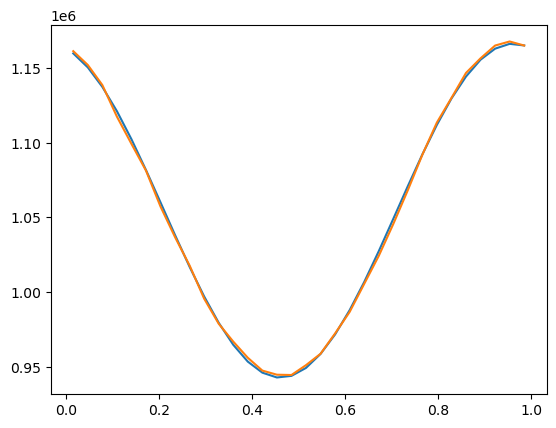

In [7]:
summed_counts = counts.sum(axis=0)

(A1, p1, c1), perr = fitsin(phase, summed_counts)
y=sinfunc(phase, A1, p1, c1)

fig, ax = plt.subplots()

ax.plot(phase, y)
ax.plot(phase,summed_counts)

summed_phase = p1-np.pi

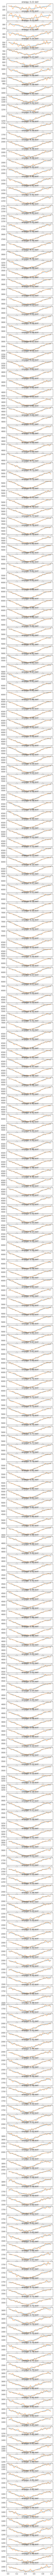

In [8]:
n_plots = n_energies
fig, axes = plt.subplots(n_energies, figsize=(5,n_plots))

fit_amplitudes = []
fit_phases = []
fit_constants = []
fit_errors = np.empty((n_energies, 3))

for i in range(n_plots):
    counts_slice = counts[i] 
    (A1, p1, c1), perr = fitsin(phase, counts_slice)
    fit_amplitudes.append(A1)
    fit_phases.append(p1)
    fit_constants.append(c1)
    fit_errors[i] = perr
    y=sinfunc(phase, A1, p1, c1)

    axes[i].plot(phase, y)
    axes[i].plot(phase,counts_slice)
    axes[i].set_title(f' energy: {energy[i]:.2f} keV')

Text(0, 0.5, 'sinus amplitude in counts/constant component')

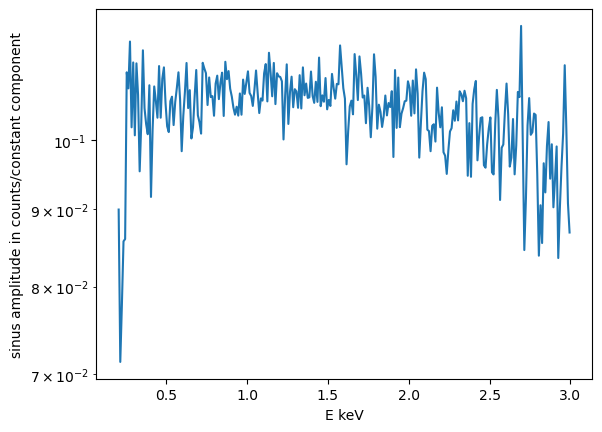

In [9]:
fig, ax = plt.subplots()
ax.semilogy(energy, abs(np.asarray(fit_amplitudes)/fit_constants))
ax.set_xlabel('E keV')
ax.set_ylabel('sinus amplitude in counts/constant component')

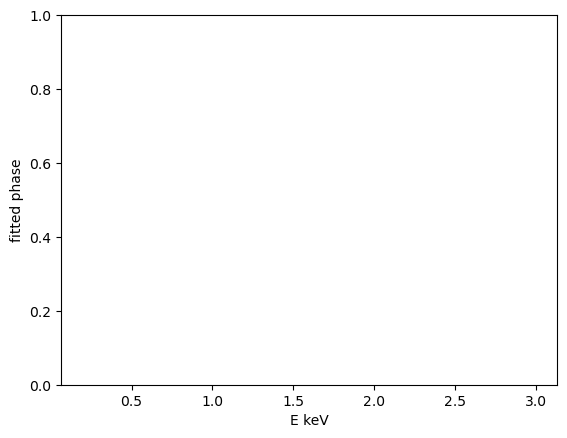

In [10]:
fig, ax = plt.subplots()
ax.plot(energy, abs(np.asarray(fit_phases-summed_phase)))
ax.set_ylim([0,1])
ax.set_xlabel('E keV')
ax.set_ylabel('fitted phase')
plt.show()

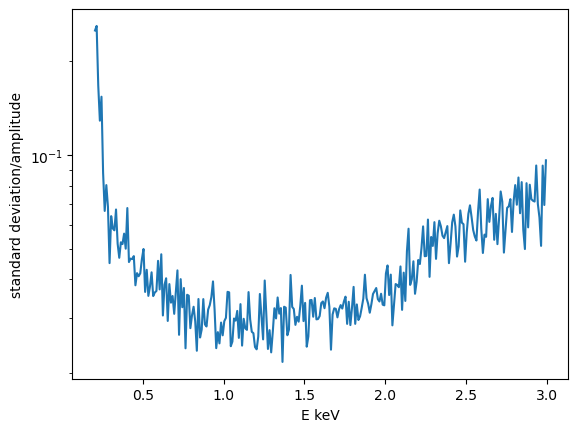

In [11]:
a1_sd = fit_errors[:,0]
sd_per_a1 = abs(a1_sd/fit_amplitudes)


fig, ax = plt.subplots()
ax.semilogy(energy, sd_per_a1)
ax.set_xlabel('E keV')
ax.set_ylabel('standard deviation/amplitude')
plt.show()

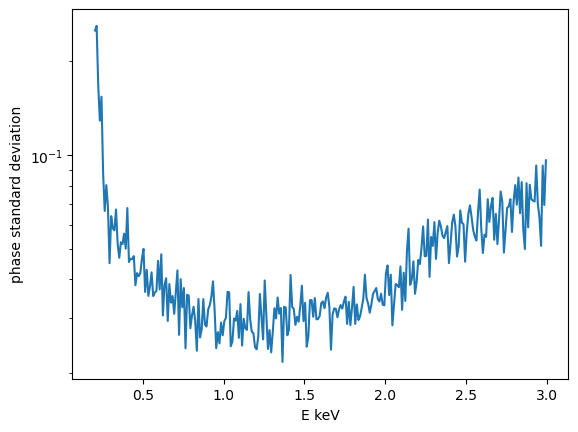

In [12]:
p1_sd = fit_errors[:,1]

fig, ax = plt.subplots()
ax.semilogy(energy, p1_sd)
ax.set_xlabel('E keV')
ax.set_ylabel('phase standard deviation')
plt.show()

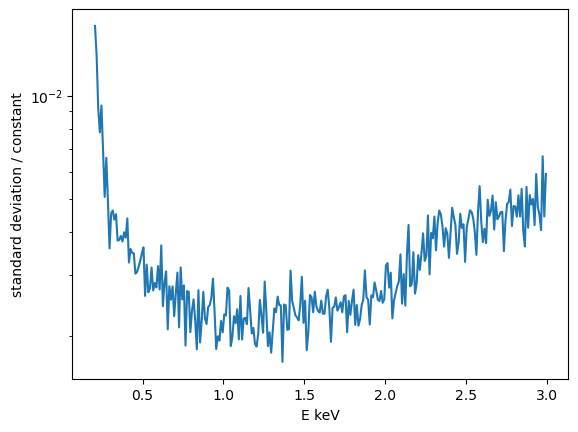

In [13]:
c1_sd = fit_errors[:,2]
sd_per_c1 = abs(c1_sd/fit_constants)

fig, ax = plt.subplots()
ax.semilogy(energy, sd_per_c1)
ax.set_xlabel('E keV')
ax.set_ylabel('standard deviation / constant')
plt.show()

## removed sines from signal

In [14]:
sines = np.empty(counts.shape)
for i, fit_amplitude, fit_phase, fit_constant in zip(range(n_energies), fit_amplitudes, fit_phases, fit_constants):
        sines[i]=sinfunc(phase, fit_amplitude, fit_phase, abs(fit_amplitude))

print(sines)

[[ 20.74437264  20.01830736  18.92838807 ...  20.53619023  21.00838704
   21.07868164]
 [ 26.29363372  25.60882909  24.44873284 ...  25.32978457  26.15137806
   26.47683009]
 [ 44.10329287  43.47667508  42.02717782 ...  40.96747926  42.82411593
   43.88295061]
 ...
 [255.97679414 244.17130943 228.0765111  ... 262.04236764 265.08738061
  263.03928708]
 [222.88676181 210.71635323 194.96409052 ... 234.01994698 234.76683089
  231.0076143 ]
 [216.33973404 206.60206284 193.22109785 ... 220.73125281 223.54273262
  222.0598982 ]]


In [15]:
background = counts-sines

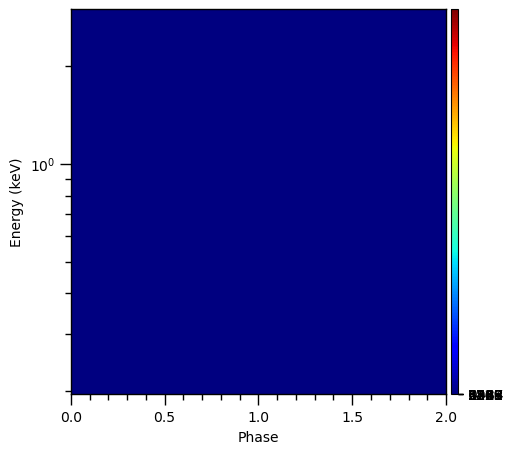

In [16]:
ax = plot_2D_pulse((background,),
                   x=phase_edge,
                   shift=[0.],
                   y=energy_edge[:-1], #channels,
                   ylabel=r'Energy (keV)',
                   figsize=(5,5),
                   cm=cm.jet,
                   num_rotations=2.0,
                   normalize=False)

plt.show()

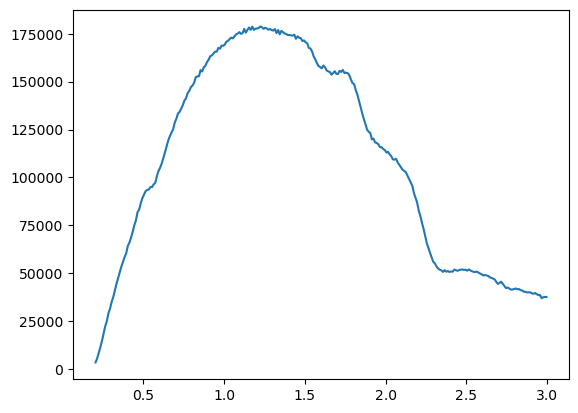

In [17]:
average_background = background.sum(axis=1)
plt.plot(energy, average_background)

In [18]:
np.savetxt('J1808_2019_nonpulsed.txt',background)

In [19]:
phase[:32]

array([0.015625, 0.046875, 0.078125, 0.109375, 0.140625, 0.171875,
       0.203125, 0.234375, 0.265625, 0.296875, 0.328125, 0.359375,
       0.390625, 0.421875, 0.453125, 0.484375, 0.515625, 0.546875,
       0.578125, 0.609375, 0.640625, 0.671875, 0.703125, 0.734375,
       0.765625, 0.796875, 0.828125, 0.859375, 0.890625, 0.921875,
       0.953125, 0.984375])

In [20]:
for i in range(len(phase)-1):
    print(phase[i+1]-phase[i])

0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125


In [21]:
np.linspace(0.015625,1.015625,33)[:-1]

array([0.015625, 0.046875, 0.078125, 0.109375, 0.140625, 0.171875,
       0.203125, 0.234375, 0.265625, 0.296875, 0.328125, 0.359375,
       0.390625, 0.421875, 0.453125, 0.484375, 0.515625, 0.546875,
       0.578125, 0.609375, 0.640625, 0.671875, 0.703125, 0.734375,
       0.765625, 0.796875, 0.828125, 0.859375, 0.890625, 0.921875,
       0.953125, 0.984375])

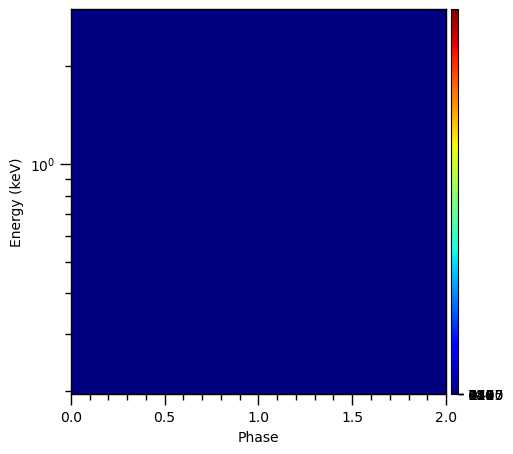

In [22]:
ax = plot_2D_pulse((sines,),
                   x=phase_edge,
                   shift=[0.],
                   y=energy_edge[:-1], #channels,
                   ylabel=r'Energy (keV)',
                   figsize=(5,5),
                   cm=cm.jet,
                   num_rotations=2.0,
                   normalize=False)

plt.show()

In [23]:
energy

array([0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265, 0.275, 0.285,
       0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.355, 0.365, 0.375,
       0.385, 0.395, 0.405, 0.415, 0.425, 0.435, 0.445, 0.455, 0.465,
       0.475, 0.485, 0.495, 0.505, 0.515, 0.525, 0.535, 0.545, 0.555,
       0.565, 0.575, 0.585, 0.595, 0.605, 0.615, 0.625, 0.635, 0.645,
       0.655, 0.665, 0.675, 0.685, 0.695, 0.705, 0.715, 0.725, 0.735,
       0.745, 0.755, 0.765, 0.775, 0.785, 0.795, 0.805, 0.815, 0.825,
       0.835, 0.845, 0.855, 0.865, 0.875, 0.885, 0.895, 0.905, 0.915,
       0.925, 0.935, 0.945, 0.955, 0.965, 0.975, 0.985, 0.995, 1.005,
       1.015, 1.025, 1.035, 1.045, 1.055, 1.065, 1.075, 1.085, 1.095,
       1.105, 1.115, 1.125, 1.135, 1.145, 1.155, 1.165, 1.175, 1.185,
       1.195, 1.205, 1.215, 1.225, 1.235, 1.245, 1.255, 1.265, 1.275,
       1.285, 1.295, 1.305, 1.315, 1.325, 1.335, 1.345, 1.355, 1.365,
       1.375, 1.385, 1.395, 1.405, 1.415, 1.425, 1.435, 1.445, 1.455,
       1.465, 1.475,

In [24]:
np.linspace(0.32, 10.48, 255)

array([ 0.32,  0.36,  0.4 ,  0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,
        0.68,  0.72,  0.76,  0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ,
        1.04,  1.08,  1.12,  1.16,  1.2 ,  1.24,  1.28,  1.32,  1.36,
        1.4 ,  1.44,  1.48,  1.52,  1.56,  1.6 ,  1.64,  1.68,  1.72,
        1.76,  1.8 ,  1.84,  1.88,  1.92,  1.96,  2.  ,  2.04,  2.08,
        2.12,  2.16,  2.2 ,  2.24,  2.28,  2.32,  2.36,  2.4 ,  2.44,
        2.48,  2.52,  2.56,  2.6 ,  2.64,  2.68,  2.72,  2.76,  2.8 ,
        2.84,  2.88,  2.92,  2.96,  3.  ,  3.04,  3.08,  3.12,  3.16,
        3.2 ,  3.24,  3.28,  3.32,  3.36,  3.4 ,  3.44,  3.48,  3.52,
        3.56,  3.6 ,  3.64,  3.68,  3.72,  3.76,  3.8 ,  3.84,  3.88,
        3.92,  3.96,  4.  ,  4.04,  4.08,  4.12,  4.16,  4.2 ,  4.24,
        4.28,  4.32,  4.36,  4.4 ,  4.44,  4.48,  4.52,  4.56,  4.6 ,
        4.64,  4.68,  4.72,  4.76,  4.8 ,  4.84,  4.88,  4.92,  4.96,
        5.  ,  5.04,  5.08,  5.12,  5.16,  5.2 ,  5.24,  5.28,  5.32,
        5.36,  5.4 ,